In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ctrl_mult_mod import ctrl_mult_mod
from math import pi

def semi_classical_QFT_inv(qc,q_reg,c_reg):
    """ Aplica a IQFT semi clássica
    
    qc : QuantumCircuit
        Circuito quântico para aplicar a IQFT
    q_reg : QuantumRegister
        Registrador quântico para a qft ser aplicada (será aplicada no 1o bit)
    c_reg : ClassicalRegister
        Registrador clássico para a medição dos qubits
    """
    try:
        n = q_reg.size
    except:
        n = len(q_reg)
    for i in range(n-1,-1,-1):
        for j in range(n-1,i,-1):
            with qc.if_test((c_reg[n-1-j],1)) as else_:
                qc.p((-pi/(2**(j-(i)))),q_reg[i])
            # with else_:
            #     pass
        qc.h(q_reg[i])
        qc.measure(q_reg[i],c_reg[n-1-i])

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1

    circuit.h(n)
    for qubit in range(n):
        if qubit >= 0:
            circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    return circuit

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n, do_swaps=False):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    if do_swaps:
        swap_registers(circuit, n)
    return circuit

def gcdExtended(a, b): 
    # Base Case 
    if a == 0 : 
        return b,0,1
             
    gcd,x1,y1 = gcdExtended(b%a, a) 
     
    # Update x and y using results of recursive 
    # call 
    x = y1 - (b//a) * x1 
    y = x1 
     
    return gcd,x,y 

def mod_inverse(x, p):
    """Retorna o inverso modular x^-1 mod p"""
    gcd, inv, _ = gcdExtended(x, p)
    if gcd != 1:
        raise ValueError("O inverso não existe")
    return inv % p

In [ ]:
from qiskit.circuit.library import QFT

"""Valores:
    b*A^x mod N : x é o valor em superposição
    b é inicializado como 1.
"""

N = 21  # N = p*q; p, q primos
n_bits = N.bit_length()

A = 2 # Base do expoente

x_bits = n_bits # q=2**x_bits, tamanho da amostra, idealmente = 2*n_bits


reg_x = QuantumRegister(x_bits, "x") # Registrador da superposição

reg_b = QuantumRegister(n_bits, "b") # Registrador do valor b, iniciado como 1

# Registradores Ancillas
reg_0 = QuantumRegister(n_bits, "0")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")


reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
expmod = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, name="expmod")

circuito = QuantumCircuit(reg_x, reg_b, reg_0, reg_cout, reg_help, reg_result)


circuito.h(reg_x)
#circuito.append(number_b, reg_b)
circuito.x(reg_b[0])

for i in range(x_bits):

        expmod.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        a_inv = mod_inverse(A**(2**i), N)

        expmod.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[i:i+1] + reg_0[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            expmod.cswap(reg_x[i], reg_b[j], reg_0[j])


circuito.append(expmod, reg_x[:] + reg_b[:] + reg_0[:] + reg_cout[:] + reg_help[:])

circuito.append(QFT(x_bits).inverse(), reg_x[:])

circuito.measure(reg_x[:], reg_result)

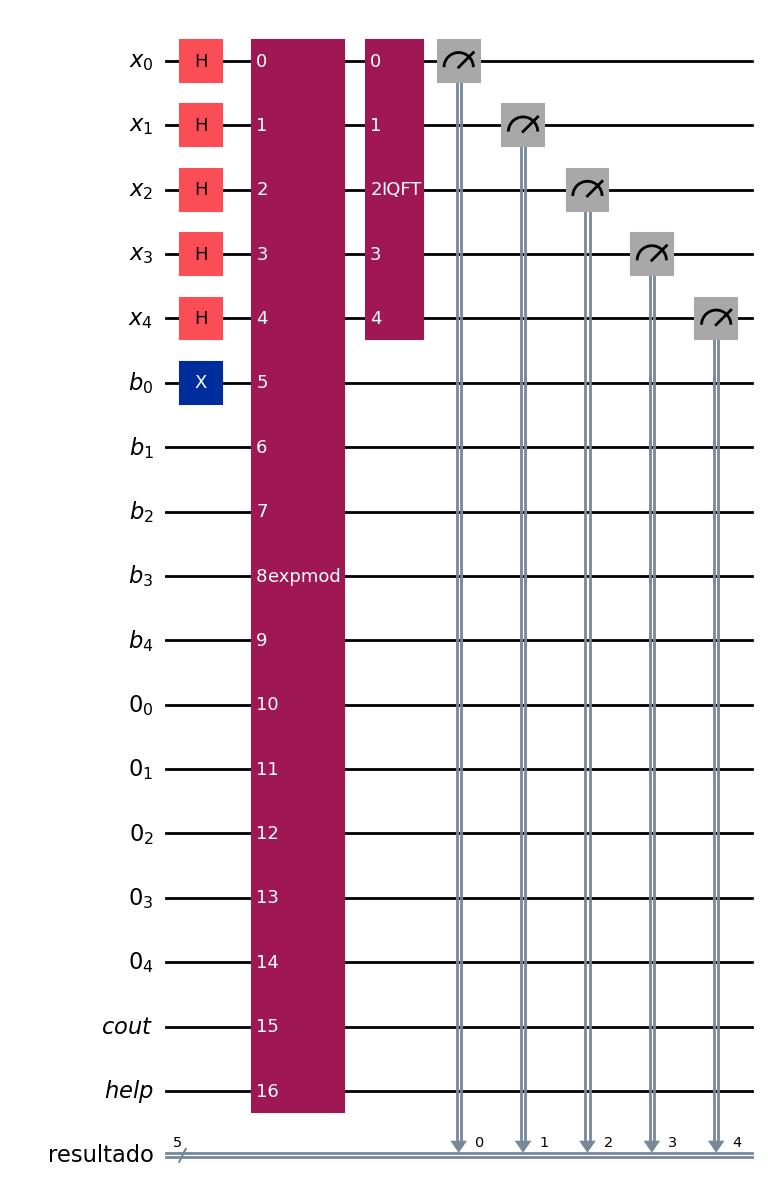

In [10]:
#expmod.draw("mpl")
circuito.draw("mpl")

In [14]:
from qiskit_aer import AerSimulator
#from qiskit_addon_aqc_tensor.simulation.aer import QiskitAerSimulationSettings
from qiskit import transpile

backend1 = AerSimulator()
qc1 = transpile(circuito, backend=backend1)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=8192)
#print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)


{0: 1360, 16: 1397, 5: 968, 21: 884, 11: 934, 12: 55, 9: 44, 6: 240, 20: 64, 4: 72, 27: 971, 25: 42, 28: 71, 10: 235, 15: 13, 22: 256, 7: 42, 8: 21, 26: 227, 1: 14, 23: 57, 19: 31, 18: 22, 17: 7, 14: 7, 3: 30, 13: 30, 29: 27, 2: 12, 24: 26, 30: 20, 31: 13}


In [15]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 1

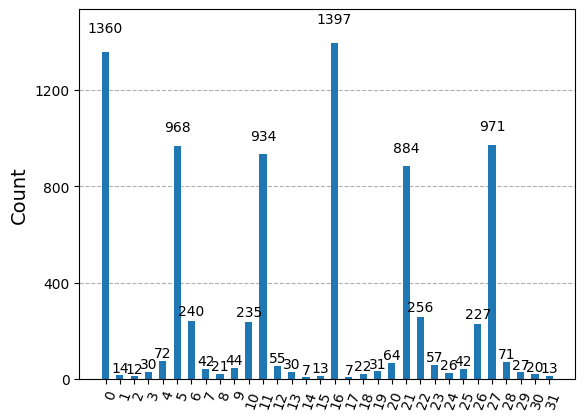

In [16]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)